In [363]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_bar, geom_point
from src.data import tables


In [364]:
return_subset_columns = [
    "SUB_ICB_LOCATION_CODE",
    "SUB_ICB_LOCATION_NAME",
    "Appointment_Date",
    "APPT_STATUS",
    "HCP_TYPE",
    "APPT_MODE",
    "TIME_BETWEEN_BOOK_AND_APPT",
    "COUNT_OF_APPOINTMENTS",
]
sub_icb_daily_df = tables.get_sub_icb_daily_df(
    return_subset_columns=return_subset_columns
)


In [365]:
# Drop NA values and Unknown Values as they are not useful
# before_size = sub_icb_daily_df.size
# sub_icb_daily_df = sub_icb_daily_df.replace(
#     'Unknown', np.NaN, inplace=False).dropna()
# after_size = sub_icb_daily_df.size
# print(before_size, after_size)

In [366]:
sub_icb_daily_appt_status_df = sub_icb_daily_df.pivot(
    index=[
        "SUB_ICB_LOCATION_CODE",
        "SUB_ICB_LOCATION_NAME",
        "Appointment_Date",
        "HCP_TYPE",
        "APPT_MODE",
        "TIME_BETWEEN_BOOK_AND_APPT",
    ],
    columns=[
        "APPT_STATUS",
    ],
    values=[
        "COUNT_OF_APPOINTMENTS",
    ],
).reset_index()

sub_icb_daily_appt_status_df.columns = [
    "_".join(col).strip().upper() if col[1] else col[0].upper()
    for col in sub_icb_daily_appt_status_df.columns.values
]

In [367]:
backup_df = sub_icb_daily_appt_status_df.copy(deep=True)


In [368]:
sub_icb_daily_appt_status_df = sub_icb_daily_appt_status_df[
    ~sub_icb_daily_appt_status_df.isin(["Unknown", "Unknown / Data Quality"])
].dropna()
sub_icb_daily_appt_status_df = sub_icb_daily_appt_status_df.drop(
    columns="COUNT_OF_APPOINTMENTS_UNKNOWN"
)

sub_icb_daily_appt_status_df.columns


Index(['SUB_ICB_LOCATION_CODE', 'SUB_ICB_LOCATION_NAME', 'APPOINTMENT_DATE',
       'HCP_TYPE', 'APPT_MODE', 'TIME_BETWEEN_BOOK_AND_APPT',
       'COUNT_OF_APPOINTMENTS_ATTENDED', 'COUNT_OF_APPOINTMENTS_DNA'],
      dtype='object')

In [386]:
appt_delay_categories = [
    "Same Day",
    "1 Day",
    "2 to 7 Days",
    "8  to 14 Days" "15  to 21 Days",
    "22  to 28 Days",
    "More than 28 Days",
]
ApptDelayCatType = pd.api.types.CategoricalDtype(
    categories=appt_delay_categories, ordered=True
)

sub_icb_daily_appt_status_df["TIME_BETWEEN_BOOK_AND_APPT"] = (
    sub_icb_daily_appt_status_df["TIME_BETWEEN_BOOK_AND_APPT"]
    .astype(dtype=ApptDelayCatType)
)

sub_icb_daily_appt_status_df["TIME_BETWEEN_BOOK_AND_APPT"]

0                      1 Day
2                2 to 7 Days
6                   Same Day
8                      1 Day
10               2 to 7 Days
                 ...        
4706732             Same Day
4706738                  NaN
4706739          2 to 7 Days
4706742    More than 28 Days
4706743             Same Day
Name: TIME_BETWEEN_BOOK_AND_APPT, Length: 1755788, dtype: category
Categories (6, object): ['Same Day' < '1 Day' < '2 to 7 Days' < '8  to 14 Days15  to 21 Days' < '22  to 28 Days' < 'More than 28 Days']

In [369]:
sub_icb_daily_appt_status_df["TOTAL_APPOINTMENTS_ATTENDED"] = (
    sub_icb_daily_appt_status_df["COUNT_OF_APPOINTMENTS_ATTENDED"]
    + sub_icb_daily_appt_status_df["COUNT_OF_APPOINTMENTS_DNA"]
)

In [370]:
def calc_status_proportions(df_input: pd.DataFrame) -> pd.DataFrame:
    df_input["PROPORTION_OF_APPOINTMENTS_ATTENDED"] = (
        df_input["COUNT_OF_APPOINTMENTS_ATTENDED"]
        / df_input["TOTAL_APPOINTMENTS_ATTENDED"]
    )
    df_input["PROPORTION_OF_APPOINTMENTS_DNA"] = (
        df_input["COUNT_OF_APPOINTMENTS_DNA"] /
        df_input["TOTAL_APPOINTMENTS_ATTENDED"]
    )
    return df_input

In [371]:
status_count_columns = [
    "COUNT_OF_APPOINTMENTS_ATTENDED",
    "COUNT_OF_APPOINTMENTS_DNA",
    "TOTAL_APPOINTMENTS_ATTENDED",
]

status_proportion_columns = [
    "PROPORTION_OF_APPOINTMENTS_ATTENDED",
    "PROPORTION_OF_APPOINTMENTS_DNA",
]

In [372]:
location_status_proportions_df = (
    sub_icb_daily_appt_status_df.copy()[
        ["SUB_ICB_LOCATION_NAME", *status_count_columns]
    ]
    .groupby("SUB_ICB_LOCATION_NAME")
    .sum()
)

location_status_proportions_df = (
    calc_status_proportions(df_input=location_status_proportions_df)
    .drop(columns=status_count_columns)
    .reset_index()
)
location_status_proportions_df.sort_values(
    by="PROPORTION_OF_APPOINTMENTS_ATTENDED")

,SUB_ICB_LOCATION_NAME,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
34,NHS Greater Manchester ICB - 14L,0.930359,0.069641
93,NHS Staffordshire and Stoke-on-Trent ICB - 05W,0.932414,0.067586
25,NHS Greater Manchester ICB - 00T,0.935073,0.064927
29,NHS Greater Manchester ICB - 01G,0.935316,0.064684
31,NHS Greater Manchester ICB - 01Y,0.935631,0.064369
...,...,...,...
99,NHS Sussex ICB - 70F,0.968407,0.031593
77,NHS Northamptonshire ICB - 78H,0.968926,0.031074
62,NHS Mid and South Essex ICB - 99E,0.969370,0.030630
96,NHS Suffolk and North East Essex ICB - 07K,0.969398,0.030602


In [373]:
location_status_proportions_df.describe()


,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
count,106.000000,106.000000
mean,0.953883,0.046117
std,0.010112,0.010112
min,0.930359,0.029173
25%,0.947028,0.037034
50%,0.954455,0.045545
75%,0.962966,0.052972
max,0.970827,0.069641


<Axes: >

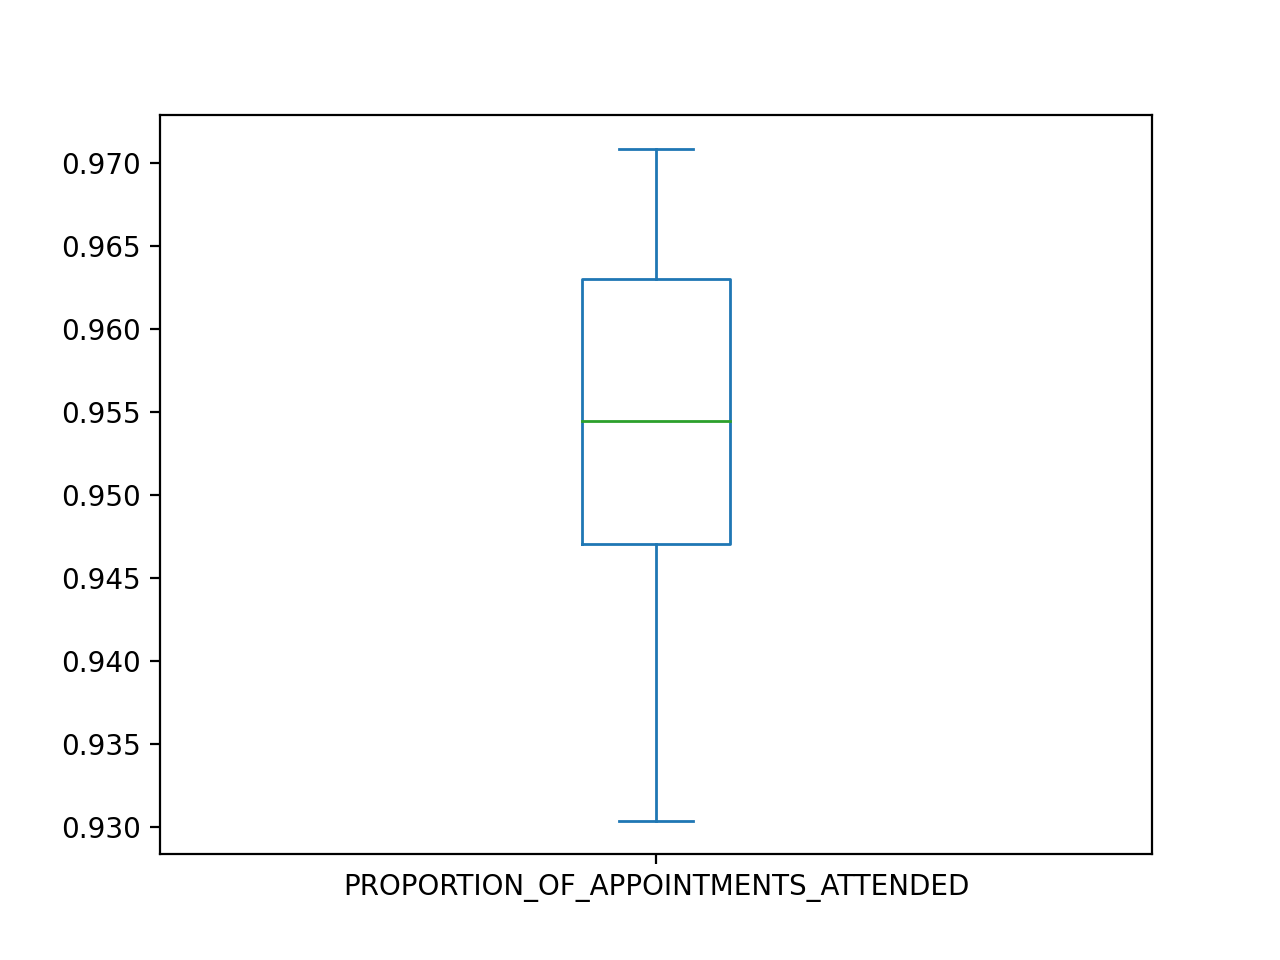

In [374]:
location_status_proportions_df.plot(
    y="PROPORTION_OF_APPOINTMENTS_ATTENDED", kind="box")

In [375]:
hcp_status_proportions_df = (
    sub_icb_daily_appt_status_df.copy()[["HCP_TYPE", *status_count_columns]]
    .groupby("HCP_TYPE")
    .sum()
)

hcp_status_proportions_df = (
    calc_status_proportions(df_input=hcp_status_proportions_df)
    .drop(columns=status_count_columns)
    .reset_index()
)
hcp_status_proportions_df.sort_values(by="PROPORTION_OF_APPOINTMENTS_ATTENDED")


,HCP_TYPE,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
1,Other Practice staff,0.932391,0.067609
0,GP,0.973869,0.026131


In [376]:
hcp_status_proportions_df.describe()


,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
count,2.000000,2.000000
mean,0.953130,0.046870
std,0.029330,0.029330
min,0.932391,0.026131
25%,0.942760,0.036501
50%,0.953130,0.046870
75%,0.963499,0.057240
max,0.973869,0.067609


In [377]:
dummy_hcp_status_proportions_df = pd.get_dummies(
    data=hcp_status_proportions_df,
    columns=["HCP_TYPE"],
).drop(columns="HCP_TYPE_Other Practice staff")
dummy_hcp_status_proportions_df


,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA,HCP_TYPE_GP
0,0.973869,0.026131,1
1,0.932391,0.067609,0


In [378]:
appt_mode_status_proportions_df = (
    sub_icb_daily_appt_status_df.copy()[["APPT_MODE", *status_count_columns]]
    .groupby("APPT_MODE")
    .sum()
)

appt_mode_status_proportions_df = (
    calc_status_proportions(df_input=appt_mode_status_proportions_df)
    .drop(columns=status_count_columns)
    .reset_index()
)
appt_mode_status_proportions_df.sort_values(
    by="PROPORTION_OF_APPOINTMENTS_ATTENDED")

,APPT_MODE,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
1,Home Visit,0.917981,0.082019
3,Video Conference/Online,0.927387,0.072613
0,Face-to-Face,0.940845,0.059155
2,Telephone,0.977943,0.022057


In [379]:
# TIME_BETWEEN_BOOK_AND_APPT
appt_delay_status_proportions_df = (
    sub_icb_daily_appt_status_df.copy()[
        ["TIME_BETWEEN_BOOK_AND_APPT", *status_count_columns]
    ]
    .groupby("TIME_BETWEEN_BOOK_AND_APPT")
    .sum()
)

appt_delay_status_proportions_df = (
    calc_status_proportions(df_input=appt_delay_status_proportions_df)
    .drop(columns=status_count_columns)
    .reset_index()
)
appt_delay_status_proportions_df.sort_values(
    by="PROPORTION_OF_APPOINTMENTS_ATTENDED")

,TIME_BETWEEN_BOOK_AND_APPT,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
5,More than 28 Days,0.885673,0.114327
3,22 to 28 Days,0.905524,0.094476
1,15 to 21 Days,0.910675,0.089325
4,8 to 14 Days,0.919756,0.080244
2,2 to 7 Days,0.938942,0.061058
0,1 Day,0.957950,0.042050
6,Same Day,0.981876,0.018124


In [391]:
sub_icb_daily_appt_status_df["APPOINTMENT_DAY"] = sub_icb_daily_appt_status_df["APPOINTMENT_DATE"].dt.day_name()
sub_icb_daily_appt_status_df["APPOINTMENT_MONTH"] = sub_icb_daily_appt_status_df["APPOINTMENT_DATE"].dt.month

In [392]:
# APPOINTMENT_DAY
day_of_week_status_proportions_df = (
    sub_icb_daily_appt_status_df.copy()[
        ["APPOINTMENT_DAY", *status_count_columns]
    ]
    .groupby("APPOINTMENT_DAY")
    .sum()
)

day_of_week_status_proportions_df = (
    calc_status_proportions(df_input=day_of_week_status_proportions_df)
    .drop(columns=status_count_columns)
    .reset_index()
)
day_of_week_status_proportions_df.sort_values(
    by="PROPORTION_OF_APPOINTMENTS_ATTENDED")

,APPOINTMENT_DAY,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
3,Sunday,0.841277,0.158723
2,Saturday,0.843690,0.156310
4,Thursday,0.953744,0.046256
6,Wednesday,0.953934,0.046066
5,Tuesday,0.954150,0.045850
0,Friday,0.956556,0.043444
1,Monday,0.959249,0.040751


In [393]:
# APPOINTMENT_MONTH
month_status_proportions_df = (
    sub_icb_daily_appt_status_df.copy()[
        ["APPOINTMENT_MONTH", *status_count_columns]
    ]
    .groupby("APPOINTMENT_MONTH")
    .sum()
)

month_status_proportions_df = (
    calc_status_proportions(df_input=month_status_proportions_df)
    .drop(columns=status_count_columns)
    .reset_index()
)
month_status_proportions_df.sort_values(
    by="PROPORTION_OF_APPOINTMENTS_ATTENDED")

,APPOINTMENT_MONTH,PROPORTION_OF_APPOINTMENTS_ATTENDED,PROPORTION_OF_APPOINTMENTS_DNA
9,10,0.944020,0.055980
11,12,0.949860,0.050140
10,11,0.950179,0.049821
8,9,0.950439,0.049561
2,3,0.954931,0.045069
0,1,0.955030,0.044970
1,2,0.955677,0.044323
7,8,0.957183,0.042817
6,7,0.957413,0.042587
3,4,0.958660,0.041340


In [380]:
# day_of_week_df = sub_icb_daily_df[
#     [*total_group_columns, "APPT_STATUS", "COUNT_OF_APPOINTMENTS"]
# ].copy(deep=True)[sub_icb_daily_df["APPT_STATUS"] != "Unknown"]

# # day_of_week_df["APPOINTMENT_DAY"] = day_of_week_df["Appointment_Date"].dt.day_name()

# day_of_week_df["APPOINTMENT_DAY_NUMBER"] = day_of_week_df[
#     "Appointment_Date"
# ].dt.day_of_week

# sum_day_of_week_df = day_of_week_df.groupby(
#     [
#         # "APPOINTMENT_DAY",
#         "APPOINTMENT_DAY_NUMBER",
#         "APPT_STATUS",
#     ]
# ).sum()

# sum_day_of_week_df["TOTAL_APPOINTMENTS"] = sum_day_of_week_df[
#     "COUNT_OF_APPOINTMENTS"
# ].sum()

# sum_day_of_week_df = sum_day_of_week_df.reset_index().sort_values(
#     "APPOINTMENT_DAY_NUMBER"
# )[["APPOINTMENT_DAY_NUMBER", "APPT_STATUS", "COUNT_OF_APPOINTMENTS"]]

# sum_day_of_week_df

In [381]:
from plotnine import geom_col


# (
#     ggplot(sum_day_of_week_df)
#     + aes(x="APPOINTMENT_DAY", y="COUNT_OF_APPOINTMENTS", fill="APPT_STATUS")
#     + geom_col(position="fill")
# )

PlotnineError: "Could not evaluate the 'x' mapping: 'APPOINTMENT_DAY' (original error: name 'APPOINTMENT_DAY' is not defined)"

In [ ]:
sum_day_of_week_df["PROPORTION_OF_APPOINTMENTS"] = (
    sum_day_of_week_df["COUNT_OF_APPOINTMENTS"]
    / sum_day_of_week_df["TOTAL_APPOINTMENTS"]
)

sum_day_of_week_df["PROPORTION_OF_APPOINTMENTS"].sum()

proportion_day_of_week_df = (
    sum_day_of_week_df.reset_index().sort_values(by="APPOINTMENT_DAY_NUMBER")[
        ["APPOINTMENT_DAY", "APPT_STATUS", "PROPORTION_OF_APPOINTMENTS"]
    ]
).reset_index(drop=True)

proportion_day_of_week_df


,APPOINTMENT_DAY,APPT_STATUS,PROPORTION_OF_APPOINTMENTS
0,Monday,Attended,0.193014
1,Monday,DNA,0.007974
2,Tuesday,Attended,0.198245
3,Tuesday,DNA,0.009193
4,Wednesday,Attended,0.188703
5,Wednesday,DNA,0.008777
6,Thursday,Attended,0.184585
7,Thursday,DNA,0.008627
8,Friday,Attended,0.174872
9,Friday,DNA,0.007657
